**Подключение библиотек и скриптов**

In [1]:
import pandas as pd
import numpy as np
import pickle
import random

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score,mean_squared_error, r2_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

C:\Users\Nataly\AppData\Roaming\Python\Python36\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [4]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1)

In [5]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [6]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [7]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance')
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

**Пути к директориям и файлам**

In [8]:
# input
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'
# output
TRAIN_FULL_PATH = 'training_project_train_full.csv'
TRAIN_PART_PATH = 'training_project_train_part_b.csv'
TEST_PART_PATH = 'training_project_test_part.csv'

SCALER_FILE_PATH = 'scaler.pkl'
MODEL_FILE_PATH = 'model.pkl'

### Загрузка данных

In [9]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [10]:
df_train.shape

(7500, 17)

In [11]:
df_train.iloc[0]

Home Ownership                            Own Home
Annual Income                               482087
Years in current job                           NaN
Tax Liens                                        0
Number of Open Accounts                         11
Years of Credit History                       26.3
Maximum Open Credit                         685960
Number of Credit Problems                        1
Months since last delinquent                   NaN
Bankruptcies                                     1
Purpose                         debt consolidation
Term                                    Short Term
Current Loan Amount                          1e+08
Current Credit Balance                       47386
Monthly Debt                                  7914
Credit Score                                   749
Credit Default                                   0
Name: 0, dtype: object

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

### Обзор данных<a class="anchor" id="review"></a>

**Обзор целевой переменной**

In [13]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

**Обзор количественных признаков**

In [14]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


Переведем признаки Tax Liens, Number of Credit Problems, Bankruptcies из количественных в категориальные поскольку они имеют малое количество вариантов значений.

In [15]:
def inttopbj(df):
    df['Tax Liens'] = df['Tax Liens'].astype('object')
    df['Number of Credit Problems'] = df['Number of Credit Problems'].astype('object')
    df['Bankruptcies'] = df['Bankruptcies'].astype('object')
    
    return df

df_train = inttopbj(df_train)

**Обзор номинативных признаков**

In [16]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Tax Liens

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
6.0       2
5.0       2
7.0       1
Name: Tax Liens, dtype: int64
****************************************************************************************************

Number of Credit Problems

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, d

In [17]:
def nom_to_cat(df):
    #срок работы группируем по годам
    df['Years in current job'] = df['Years in current job'].map({'10+ years':'4', '9 years':'3', '8 years':'3',
                                                                 '7 years':'3', '6 years':'2', '5 years':'2',
                                                                 '4 years':'2', '3 years':'1', '2 years':'1',
                                                                 '1 year':'1', '< 1 year':'0'}).astype(object)
    
    df['Home Ownership'] = df['Home Ownership'].map({'Home Mortgage':'1','Own Home':'2','Rent':'3',
                                                    'Have Mortgage':'4'}).astype(object)
    
    #цель кредита также сгруппируем пот тематике 
    df['Purpose'] = df['Purpose'].map({'debt consolidation':'1','other':'2','home improvements':'3',
                                      'business loan':'4','buy a car':'5','medical bills':'6',
                                      'major purchase':'5','take a trip':'7','buy house':'3','small business':'8',
                                      'renewable energy':'2', 'vacation':'7', 'educational expenses':'9',
                                      'moving':'3', 'wedding':'7'}).astype(object)
    
    df['Term'] = df['Term'].map({'Short Term':'0', 'Long Term':'1'}).astype(object)
    return df

In [18]:
df_train = nom_to_cat(df_train)

### Обработка пропусков<a class="anchor" id="gaps"></a>

In [19]:
len(df_train) - df_train.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

Видно что у признаков "Annual Income", "Years in current job", "Months since last delinquent", "Bankruptcies" и "Credit Score" есть пропущенные значения, необходимо их заполнить.


Т.к. у признака "Months since last delinquent" пропущена более чем половина значений, удалим этот признак из выборки, поскольку заполнить пропуски по нему является проблематичным.

In [20]:
def dropMsld(df):
    df = df.drop(['Months since last delinquent'], axis=1)
    return df

In [21]:
df_train = dropMsld(df_train)

Пустые значения признака "Bankruptcies", "Home Ownership", "Purpose" модой этих признаков

In [22]:
def fillBankruptcies(df):
    df['Bankruptcies']  = df['Bankruptcies'].fillna(df['Bankruptcies'].mode()[0]).astype(object)
    return df

In [23]:
df_train = fillBankruptcies(df_train)

Признак Years in current job заполним пропуски 'Years of Credit History'

In [24]:
df_train['Years in current job'].value_counts()

4    2332
1    1829
2    1411
3     994
0     563
Name: Years in current job, dtype: int64

In [25]:
def fillYears_job(df):
    df.loc[(df['Years of Credit History'] >= 10.0) & (df['Years in current job'].isna()), 'Years in current job'] = '4'
    df.loc[(df['Years of Credit History'] < 10) & (df['Years of Credit History'] > 6) & (df['Years in current job'].isna()), 
           'Years in current job'] = '3'
    df.loc[(df['Years of Credit History'] < 6) & (df['Years of Credit History'] > 3) & (df['Years in current job'].isna()), 
           'Years in current job'] = '2'
    df.loc[(df['Years of Credit History'] < 3) & (df['Years of Credit History'] >= 1) & (df['Years in current job'].isna()), 
           'Years in current job'] = '1'
    df.loc[(df['Years of Credit History'] < 1) & (df['Years in current job'].isna()), 
           'Years in current job'] = '0'
    return df

In [26]:
df_train = fillYears_job(df_train)

Теперь функции для заполнения Annual Income и Credit Score, эти признаки заполним с помощью регерессии.

In [27]:
def fillAnnualInc(df):
    data = df.copy()
    data = data.drop('Credit Score', axis=1)
    
    X = data.loc[data['Annual Income'].notna(),:].drop('Annual Income', axis=1)
    y = data.loc[data['Annual Income'].notna(),'Annual Income']
    
    X_1 = data.loc[data['Annual Income'].isnull(),:].drop('Annual Income', axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)
    
    reg = LinearRegression()
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    annual_inc = pd.Series(reg.predict(X_1))
    
    for value in annual_inc:
        df.loc[df['Annual Income'].isnull(), 'Annual Income'] = value
    
    return df

In [28]:
def fillCreditScore(df):
    data = df.copy()
    data = data.drop('Annual Income', axis=1)
    
    X = data.loc[data['Credit Score'].notna(),:].drop('Credit Score', axis=1)
    y = data.loc[data['Credit Score'].notna(),'Credit Score']
    
    X_1 = data.loc[data['Credit Score'].isnull(),:].drop('Credit Score', axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)
    
    reg = LinearRegression()
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    cred_score = pd.Series(reg.predict(X_1))

    for value in cred_score:
        df.loc[df['Credit Score'].isnull(), 'Credit Score'] = value
    
    return df

In [29]:
df_train = fillAnnualInc(df_train)
df_train = fillCreditScore(df_train)

### Обработка выбросов

In [30]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

1    3637
3    3204
2     647
4      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

4    2686
1    1829
2    1412
3    1010
0     563
Name: Years in current job, dtype: int64
****************************************************************************************************

Tax Liens

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
6.0       2
5.0       2
7.0       1
Name: Tax Liens, dtype: int64
****************************************************************************************************

Number of Credit Problems

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64
****************************************************************************************************

Bankruptcies

0.0    6674
1.0     786
2.0      31
3.0       7
4.0       2
Name: Ba

##### Home Ownership

In [31]:
df_train.loc[df_train['Home Ownership'] == '4', 'Home Ownership'] = '1'

##### Tax Liens

In [32]:
df_train.loc[(df_train['Tax Liens'] == 7) | (df_train['Tax Liens'] == 6) | (df_train['Tax Liens'] == 5)
             | (df_train['Tax Liens'] == 4), 'Tax Liens'] = 3
df_train['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      21
Name: Tax Liens, dtype: int64

##### Number of Credit Problems

In [33]:
df_train.loc[(df_train['Number of Credit Problems'] == 7) | (df_train['Number of Credit Problems'] == 6) | 
             (df_train['Number of Credit Problems'] == 5)
             | (df_train['Number of Credit Problems'] == 4), 'Number of Credit Problems'] = 3
df_train['Number of Credit Problems'].value_counts()

0.0    6469
1.0     882
2.0      93
3.0      56
Name: Number of Credit Problems, dtype: int64

##### Bankruptcies

In [34]:
df_train.loc[df_train['Bankruptcies'] == 4, 'Bankruptcies'] = 3
df_train['Bankruptcies'].value_counts()

0.0    6674
1.0     786
2.0      31
3.0       9
Name: Bankruptcies, dtype: int64

#### С помощью violinplot просмотрим количественные признаки на выбросы:

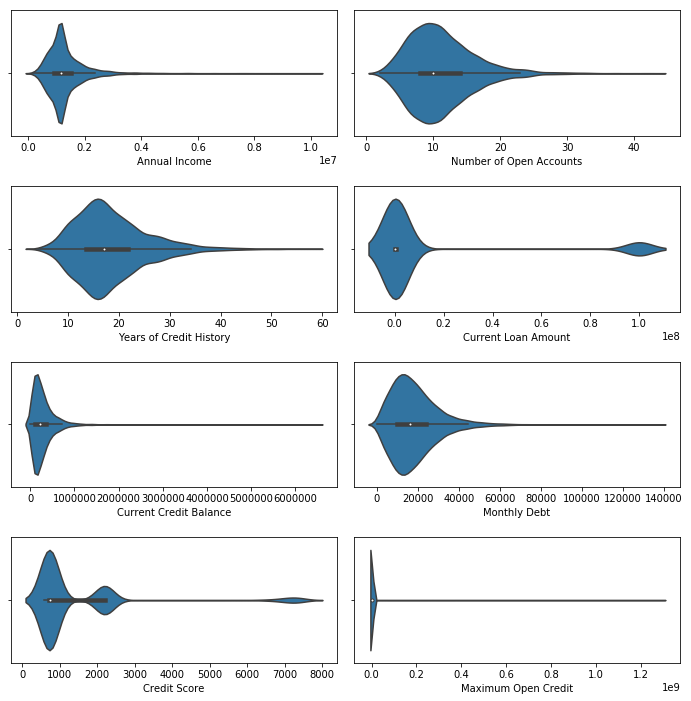

In [35]:
fig, ax = plt.subplots(nrows=4, ncols=2)
ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = ax.flatten()

sns.violinplot(x='Annual Income', data=df_train, ax=ax1)
sns.violinplot(x='Number of Open Accounts', data=df_train, ax=ax2)
sns.violinplot(x='Years of Credit History', data=df_train, ax=ax3)
sns.violinplot(x='Current Loan Amount', data=df_train, ax=ax4)
sns.violinplot(x='Current Credit Balance', data=df_train, ax=ax5)
sns.violinplot(x='Monthly Debt', data=df_train, ax=ax6)
sns.violinplot(x='Credit Score', data=df_train, ax=ax7)
sns.violinplot(x='Maximum Open Credit', data=df_train, ax=ax8)

fig.set_size_inches(12, 12)

plt.subplots_adjust(wspace=0.05, hspace=0.4)

##### Проанализировав графики, я объеденю 2 признака - 'Annual Income' и 'Current Loan Amount' и удалю строки, которые выходят за пределы 'усов' их boxplot'ов

In [36]:
def drop_anninc_curamnt(df):
    df = df.drop(df[df['Annual Income'] > 2300000].index)
    df = df.drop(df[df["Current Loan Amount"] > 950000].index)
    return df

df_train = drop_anninc_curamnt(df_train)

###### Далее на основании графиков напишем функции для обработки выбросов по другим признакам

In [37]:
def prep_numOfAcc(df):
    df.loc[df['Number of Open Accounts'] > 20, 'Number of Open Accounts'] = np.round(df['Number of Open Accounts'].mean())
    return df

df_train = prep_numOfAcc(df_train)

In [38]:
def years_credit_his(df):
    df.loc[df['Years of Credit History'] > 35, 'Years of Credit History'] = np.round(df['Years of Credit History'].mean())
    return df

df_train = years_credit_his(df_train)

In [39]:
def bal_debt_open(df):
    df = df.drop(df.loc[(df['Current Credit Balance'] > 750000)&(df['Monthly Debt'] > 45000)
             &(df['Maximum Open Credit'] > 1000000)].index)
    return df

df_train = bal_debt_open(df_train)

In [40]:
def month_debt(df):
    df = df.drop(df.loc[df['Monthly Debt'] > 45000, 'Monthly Debt'].index)
    return df

df_train = month_debt(df_train)

In [41]:
def cred_bal(df):
    df.loc[df['Current Credit Balance'] > 750000, 'Current Credit Balance'] = np.round(df['Current Credit Balance'].mean())
    return df

df_train = cred_bal(df_train)

In [42]:
def cred_score(df):
    df_train.loc[df_train['Credit Score'] > 6000, 'Credit Score'] = np.round(df['Credit Score'].mean())
    return df

df_train = cred_score(df_train)

In [43]:
def open_cred(df):
    df.loc[df['Maximum Open Credit'] > 1000000, 'Maximum Open Credit'] = np.round(df['Maximum Open Credit'].mean())
    return df

df_train = open_cred(df_train)

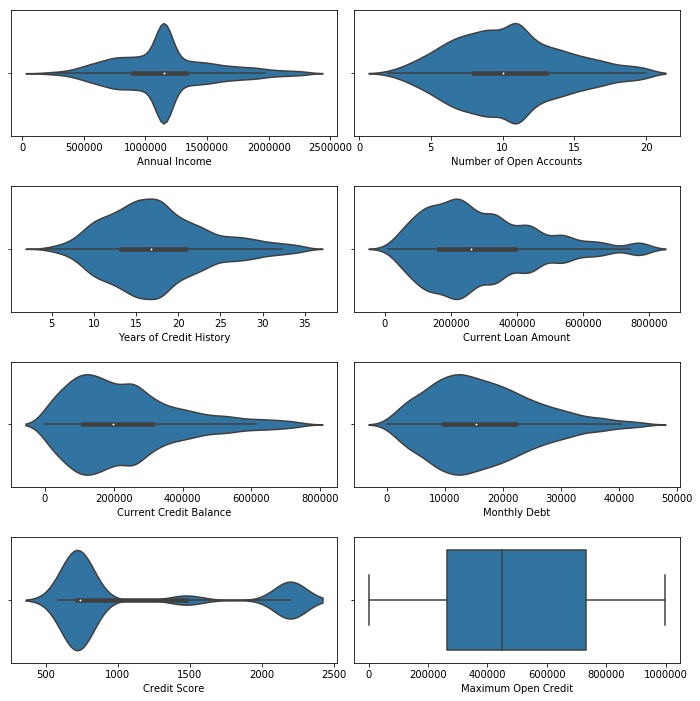

In [44]:
fig, ax = plt.subplots(nrows=4, ncols=2)
ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = ax.flatten()

sns.violinplot(x='Annual Income', data=df_train, ax=ax1)
sns.violinplot(x='Number of Open Accounts', data=df_train, ax=ax2)
sns.violinplot(x='Years of Credit History', data=df_train, ax=ax3)
sns.violinplot(x='Current Loan Amount', data=df_train, ax=ax4)
sns.violinplot(x='Current Credit Balance', data=df_train, ax=ax5)
sns.violinplot(x='Monthly Debt', data=df_train, ax=ax6)
sns.violinplot(x='Credit Score', data=df_train, ax=ax7)
sns.boxplot(x='Maximum Open Credit', data=df_train, ax=ax8)

fig.set_size_inches(12, 12)

plt.subplots_adjust(wspace=0.05, hspace=0.4)

### Построение новых признаков<a class="anchor" id="new_features"></a>

In [45]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME).tolist()

#### Credit Score

Т.к. значения признака Credit Score имеют три интервала значений, пеерведем их в значения 0, 1, где 0 - Credit Score менее 1500, 1 - Credit Score более 1500 

In [46]:
def cred_st_dm(df):
    df.loc[df['Credit Score'] < 800, 'Credit Score'] = 0
    df.loc[df['Credit Score'] > 1000, 'Credit Score'] = 1
    
    return df

df_train = cred_st_dm(df_train)

#### Id

In [47]:
def get_id(df):
    df['Id'] = df.index.tolist()
    
    return df

df_train = get_id(df_train)

#### создадим dummie переменные

In [48]:
def get_dummies(df):
    for cat_colname in df.select_dtypes(include='object').columns[1:]:
        df = pd.concat([df, pd.get_dummies(df[cat_colname], prefix=cat_colname, dtype='int64')], axis=1)
    return df

In [49]:
df_train = get_dummies(df_train)
df_train.head(1)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,...,Purpose_2,Purpose_3,Purpose_4,Purpose_5,Purpose_6,Purpose_7,Purpose_8,Purpose_9,Term_0,Term_1
1,2,1025487.0,4,0,15.0,15.3,883755.0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


### Итоговая функция для обработки данных

In [50]:
def prepare_data(df):
    df = inttopbj(df)
    df = nom_to_cat(df)
    df = dropMsld(df)
    df = fillBankruptcies(df)
    df = fillYears_job(df)
    df = fillAnnualInc(df)
    df = fillCreditScore(df)
    df = cred_st_dm(df)
    df = get_dummies(df)
    df = get_id(df)

    return df

#### Выделение целевой переменной и групп признаков

In [51]:
NEW_FEATURE_NAMES = df_train.columns.drop([TARGET_NAME, 'Id'] + BASE_FEATURE_NAMES).tolist()

In [52]:
df_train[TARGET_NAME].value_counts()

0    4072
1    1971
Name: Credit Default, dtype: int64

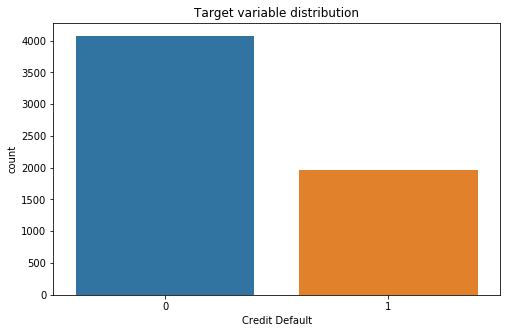

In [53]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df_train)

plt.title('Target variable distribution')
plt.show()

#### Корреляция с базовыми признаками

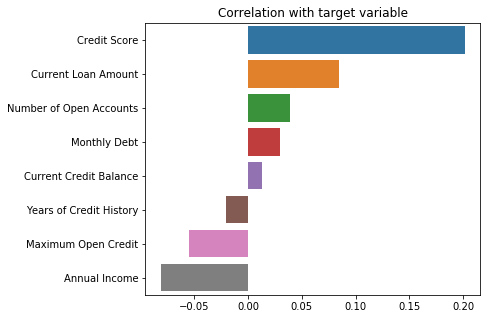

In [54]:
corr_with_target = df_train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(6, 5))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

#### Оценка признака "Credit Score" в разрезе целевой переменной

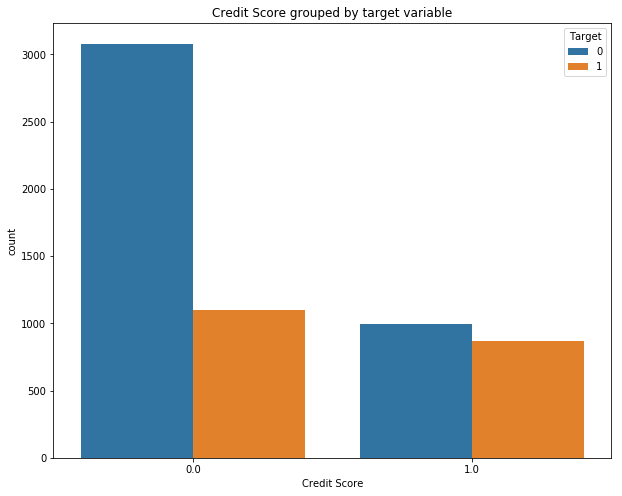

In [55]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Credit Score", hue=TARGET_NAME, data=df_train)
plt.title('Credit Score grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

Из гистограммы видно, что при значении Credit score = 0, целевая переменная принимает значение 0 в гораздо большей степени ,чем при Credit Score = 1. 

In [56]:
crSc_and_target_s = df_train.loc[df_train['Credit Score'].isin([1, 0]), ['Id', 'Credit Score', 'Credit Default']]

In [57]:
table = crSc_and_target_s.pivot_table(values='Id', index='Credit Score', columns='Credit Default', aggfunc='count')
table

Credit Default,0,1
Credit Score,,
0.0,3080,1099
1.0,992,872


In [58]:
chi2, p, dof, expected = chi2_contingency(table, correction=False)
p

1.8657320576222952e-55

#### Оценка признака "Annual Income" в разрезе целевой переменной

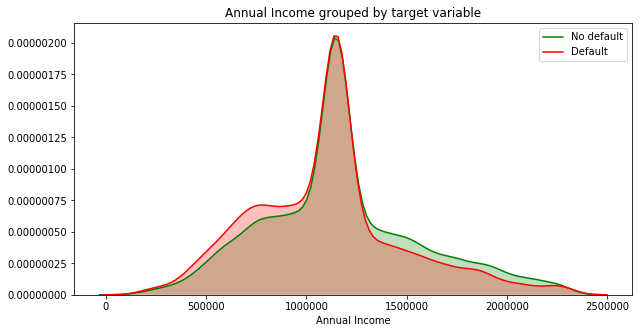

In [59]:
annual_income_with_target_s = df_train[['Annual Income', TARGET_NAME]]
annual_income_s = annual_income_with_target_s['Annual Income']
annual_income_target_0 = annual_income_s[annual_income_with_target_s[TARGET_NAME] == 0]
annual_income_target_1 = annual_income_s[annual_income_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(annual_income_target_0, shade=True, label='No default', color='g')
sns.kdeplot(annual_income_target_1, shade=True, label='Default', color='r')

plt.xlabel('Annual Income')
plt.title('Annual Income grouped by target variable')
plt.show()

**Наблюдение**

Похоже что две группы, полученные в результате разбиения признака "Annual Income" по целевой переменной, имеют различные распределения, что может помочь при построение модели, т.к. это будет означать, что между признаком "Annual Income" и целевой переменной, возможно, существует некоторая функциональная зависимость.

**Гипотеза** 
* Нулевая гипотеза: средние значения в двух независимых выборках равны
* Альтернативная гипотеза: средние значения в двух независимых выборках различаются
* Критерий: критерий Стьюдента (t-тест) и его аналоги
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

Что бы проверить данную гипотезу сравним две выборки из рассматриваемых групп на предмет равенства средних значений.
Если вероятность того, что мат. ожидания в исходных группах равны, при данных выборках, буде менее 5%, то можно будет говорить о том, что скорее всего выборки имеют различные распределения.

In [60]:
shapiro(annual_income_s)

(0.9634820818901062, 1.560982634889424e-36)

По полученному значению p-value, которое сильно меньше 0.05, можем заключить, что гипотеза о "нормальности" отвергается.

*Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график*

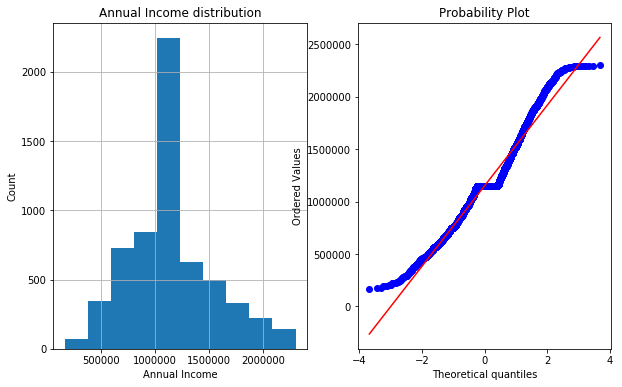

In [61]:
plt.figure(figsize=(10, 6))

ax1 = plt.subplot(121)
ax1.set_xlabel('Annual Income')
ax1.set_ylabel('Count')
ax1.set_title('Annual Income distribution')
annual_income_s.hist()

plt.subplot(122)
probplot(annual_income_s, dist='norm', plot=plt)

plt.show()

Визуальная оценка подтверждает показания критерия Шапиро-Уилка по поводу того, что закон распределения отличный от "нормального", в связи с чем, мы не сможем воспользоваться критерием Стьюдента для проверки гипотезы о равности мат. ожиданий признака Annual Income в группах, но мы сможем воспользоваться его непараметрическим аналогом - критерием Манна-Уитни, который не требователен к закону распределения.

In [62]:
mannwhitneyu(annual_income_target_0, annual_income_target_1)

MannwhitneyuResult(statistic=3601920.0, pvalue=3.654224873528413e-11)

Согласно значению p-value, гипотеза о равности мат. ожиданий отвергается, но стоит ради дополнительной проверки обратиться к доверительным интервалам.

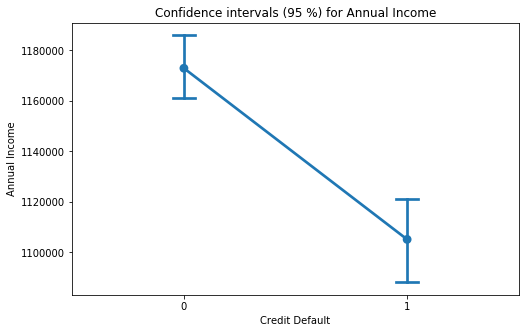

In [63]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Annual Income', data=annual_income_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for Annual Income')
plt.show()

По данному графику так же видно, что интервалы, в которых с 95% вероятностью должны находится истинные мат. ожидания этих двух групп, не пересекаются, что подтверждает результаты полученные с помощью критерия Манна-Уитни.

Это означает, что группы из которых взяты данные выборки, с допускаемой нами вероятностью (95%), имеют различные распределения и этот признак может быть полезен для определения значения целевой переменной.

### Анализ признакового пространства

#### Матрица корреляций

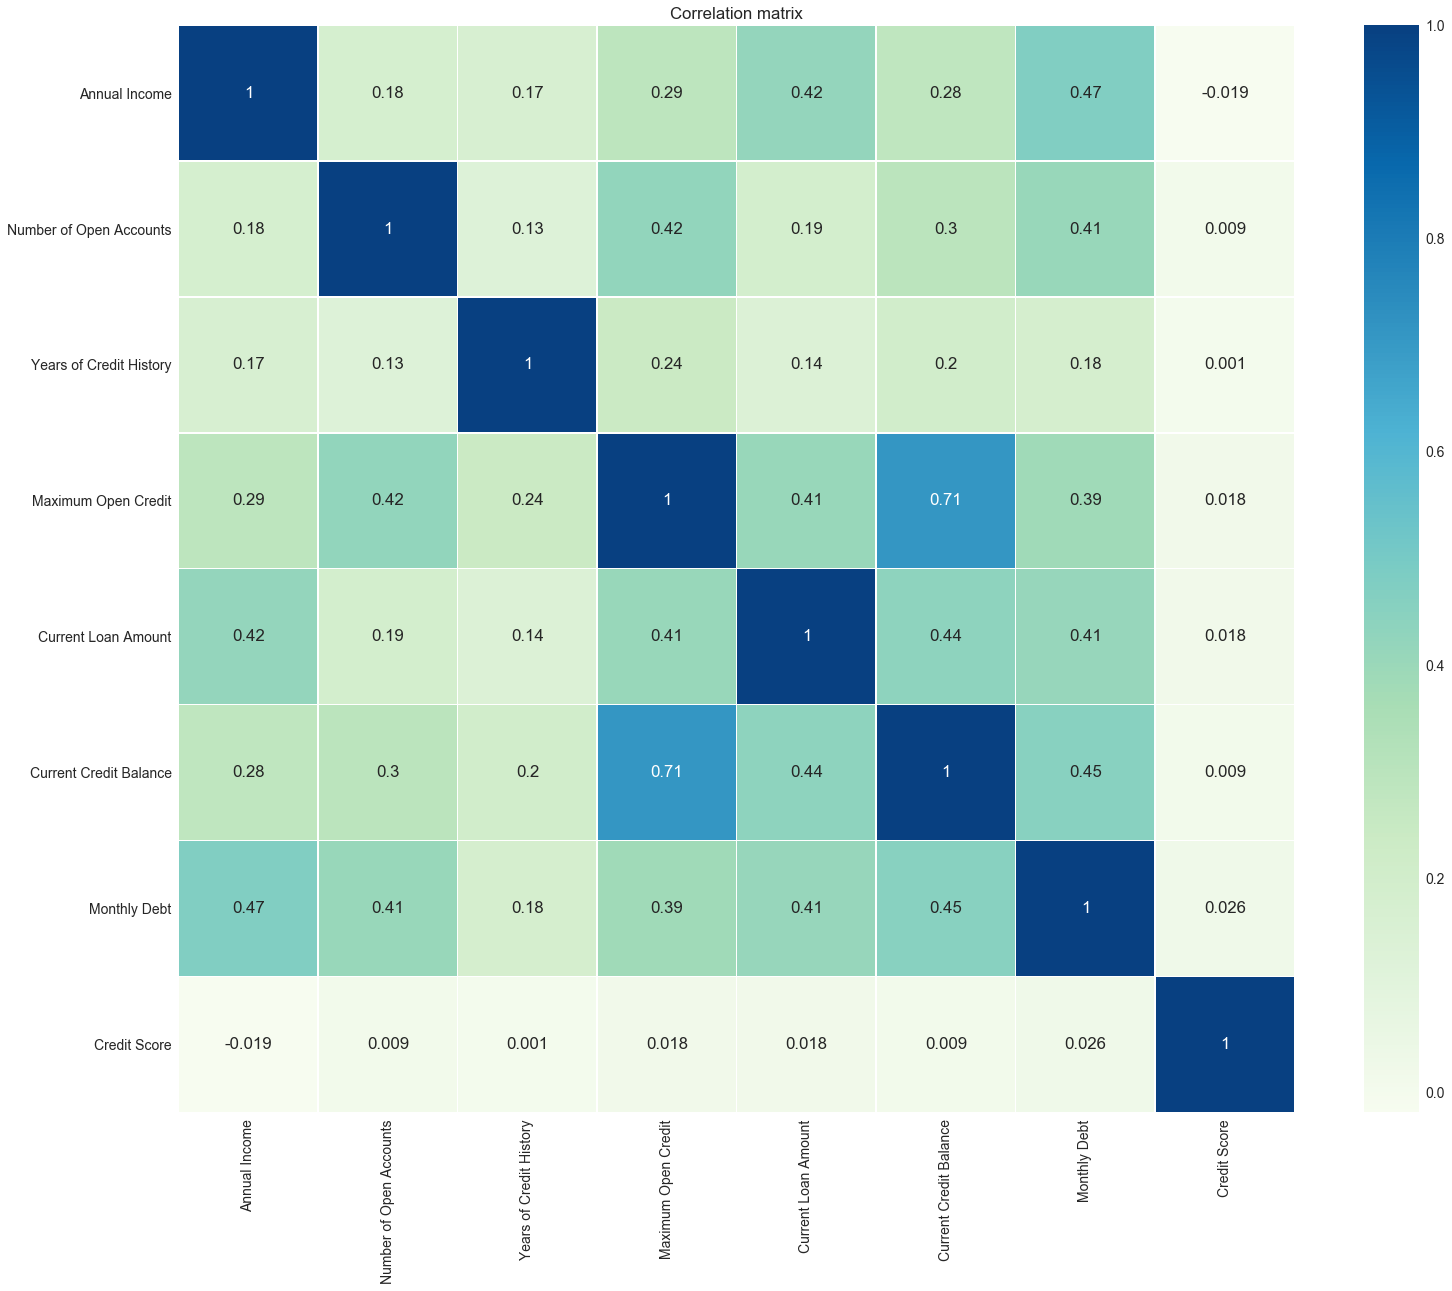

In [64]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(df_train[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

### Отбор признаков<a class="anchor" id="feature_selection"></a>

In [65]:
NUM_FEATURE_NAMES = ['Annual Income', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 
                     'Number of Credit Problems', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt']

CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Tax Liens', 'Bankruptcies', 'Purpose', 'Term']

SELECTED_FEATURE_NAMES = NEW_FEATURE_NAMES + NUM_FEATURE_NAMES

### Приведение типов для модели CatBoost

In [66]:
for colname in CAT_FEATURE_NAMES:
    df_train[colname] = pd.Categorical(df_train[colname])
    
df_train[CAT_FEATURE_NAMES].dtypes

Home Ownership          category
Years in current job    category
Tax Liens               category
Bankruptcies            category
Purpose                 category
Term                    category
dtype: object

### Нормализация данных<a class="anchor" id="normalization"></a>

In [67]:
scaler = StandardScaler()

df_norm = df_train.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

df_train = df_norm.copy()

**Сохранение модели для нормализации данных**

In [68]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

### Разбиение на train и test<a class="anchor" id="train_and_test"></a>

In [69]:
X = df_train[SELECTED_FEATURE_NAMES]
y = df_train[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

### Балансировка целевой переменной<a class="anchor" id="target_balancing"></a>

In [70]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    2867
1    2726
Name: Credit Default, dtype: int64

In [71]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

### Сохранение обучающего и тестового датасетов<a class="anchor" id="train_test_saving"></a> 

In [72]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [73]:
df_train.to_csv(TRAIN_FULL_PATH, index=False, encoding='utf-8')
train.to_csv(TRAIN_PART_PATH, index=False, encoding='utf-8')
test.to_csv(TEST_PART_PATH, index=False, encoding='utf-8')

### Построение и оценка базовых моделей<a class="anchor" id="baseline_modeling"></a> 

**Логистическая регрессия**

In [74]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.62      0.66      0.64      2867
           1       0.62      0.57      0.59      2726

    accuracy                           0.62      5593
   macro avg       0.62      0.62      0.62      5593
weighted avg       0.62      0.62      0.62      5593

TEST

              precision    recall  f1-score   support

           0       0.74      0.68      0.71      1205
           1       0.45      0.53      0.49       608

    accuracy                           0.63      1813
   macro avg       0.60      0.60      0.60      1813
weighted avg       0.64      0.63      0.63      1813

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               814  391
1               287  321


**k ближайших соседей**

In [75]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.73      0.78      0.76      2867
           1       0.75      0.70      0.73      2726

    accuracy                           0.74      5593
   macro avg       0.74      0.74      0.74      5593
weighted avg       0.74      0.74      0.74      5593

TEST

              precision    recall  f1-score   support

           0       0.71      0.66      0.68      1205
           1       0.40      0.46      0.43       608

    accuracy                           0.59      1813
   macro avg       0.56      0.56      0.56      1813
weighted avg       0.60      0.59      0.60      1813

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               796  409
1               331  277


**Бустинговые алгоритмы**

*XGBoost*

In [76]:
model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      2867
           1       0.98      0.97      0.97      2726

    accuracy                           0.97      5593
   macro avg       0.97      0.97      0.97      5593
weighted avg       0.97      0.97      0.97      5593

TEST

              precision    recall  f1-score   support

           0       0.70      0.75      0.72      1205
           1       0.42      0.36      0.39       608

    accuracy                           0.62      1813
   macro avg       0.56      0.55      0.56      1813
weighted avg       0.61      0.62      0.61      1813

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               906  299
1               391  217


*LightGBM*

In [77]:
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      2867
           1       0.91      0.91      0.91      2726

    accuracy                           0.91      5593
   macro avg       0.91      0.91      0.91      5593
weighted avg       0.91      0.91      0.91      5593

TEST

              precision    recall  f1-score   support

           0       0.71      0.73      0.72      1205
           1       0.44      0.42      0.43       608

    accuracy                           0.62      1813
   macro avg       0.57      0.57      0.57      1813
weighted avg       0.62      0.62      0.62      1813

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               874  331
1               353  255


*CatBoost*

In [78]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      2867
           1       0.87      0.84      0.85      2726

    accuracy                           0.86      5593
   macro avg       0.86      0.86      0.86      5593
weighted avg       0.86      0.86      0.86      5593

TEST

              precision    recall  f1-score   support

           0       0.73      0.76      0.74      1205
           1       0.48      0.44      0.46       608

    accuracy                           0.65      1813
   macro avg       0.60      0.60      0.60      1813
weighted avg       0.64      0.65      0.65      1813

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               911  294
1               341  267


### Выбор лучшей модели и подбор гиперпараметров<a class="anchor" id="tuning_best_model"></a> 

In [79]:
model_catb = catb.CatBoostClassifier(class_weights=[1, 2], silent=True, random_state=21)

**Подбор гиперпараметров**

In [80]:
params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500],
          'max_depth':[3, 5, 7]}

In [81]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [82]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)

Wall time: 1min 24s


In [83]:
rs.best_params_

{'n_estimators': 1200, 'max_depth': 3}

In [84]:
rs.best_score_

0.48130529103045244

**Обучение и оценка финальной модели**

In [85]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=500, max_depth=3,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.70      0.73      0.71      2867
           1       0.70      0.67      0.68      2726

    accuracy                           0.70      5593
   macro avg       0.70      0.70      0.70      5593
weighted avg       0.70      0.70      0.70      5593

TEST

              precision    recall  f1-score   support

           0       0.75      0.71      0.73      1205
           1       0.48      0.52      0.50       608

    accuracy                           0.65      1813
   macro avg       0.61      0.62      0.61      1813
weighted avg       0.66      0.65      0.65      1813

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               860  345
1               294  314
Wall time: 1.5 s


### Снижение степени переобучения<a class="anchor" id="lowering_overfitting"></a>

In [86]:
final_model = catb.CatBoostClassifier(n_estimators=500, max_depth=3, l2_leaf_reg=14,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.67      0.72      0.69      2867
           1       0.68      0.63      0.65      2726

    accuracy                           0.67      5593
   macro avg       0.67      0.67      0.67      5593
weighted avg       0.67      0.67      0.67      5593

TEST

              precision    recall  f1-score   support

           0       0.75      0.72      0.74      1205
           1       0.49      0.52      0.50       608

    accuracy                           0.66      1813
   macro avg       0.62      0.62      0.62      1813
weighted avg       0.66      0.66      0.66      1813

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               872  333
1               292  316


### Подбор оптимального размера выборки, кривая обучения<a class="anchor" id="learning_curve"></a>

In [87]:
final_model = catb.CatBoostClassifier(n_estimators=500, max_depth=3, l2_leaf_reg=14,
                                      silent=True, random_state=21)

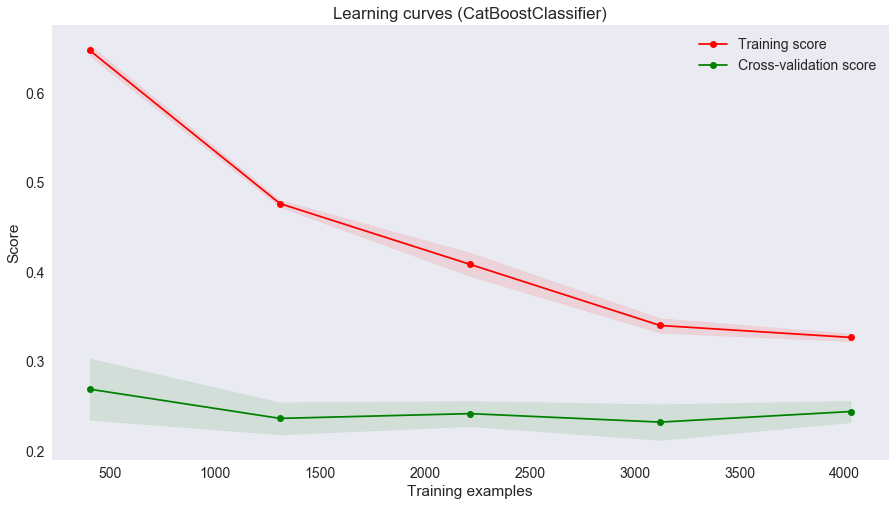

In [88]:
show_learning_curve_plot(final_model, X, y)

### Выбор порога вероятности для определения класса<a class="anchor" id="threshold_calibration"></a>

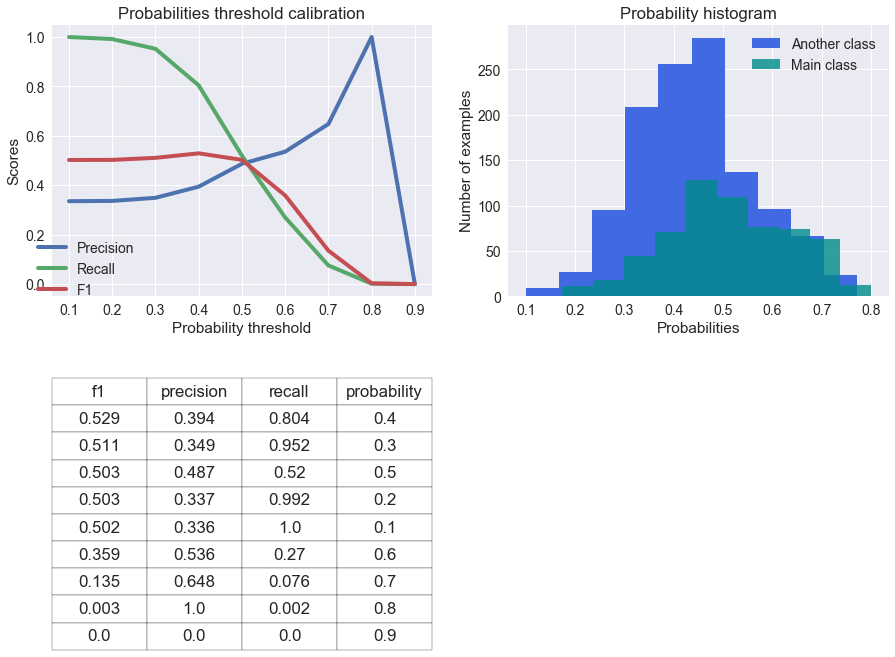

In [89]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

### Важность признаков<a class="anchor" id="feature_importances"></a>

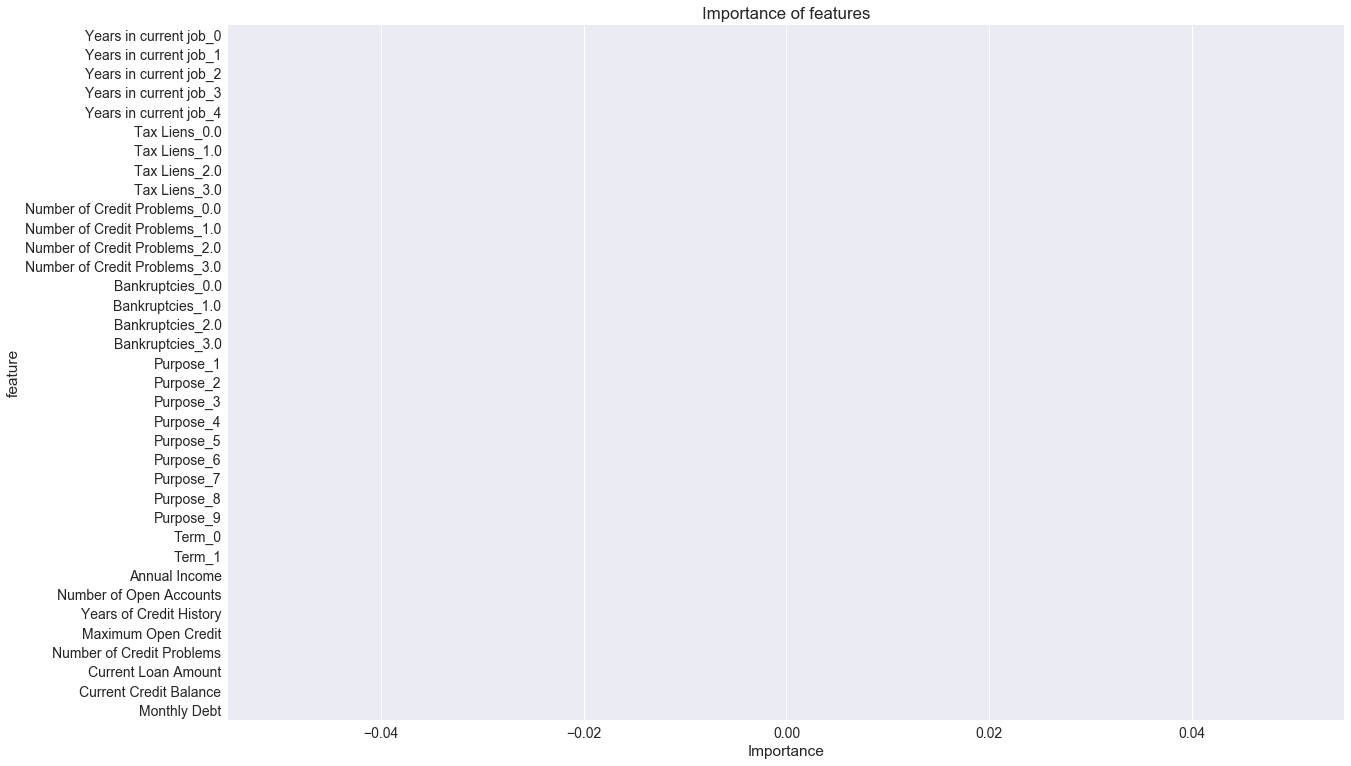

In [90]:
important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_, get_top=15)

In [91]:
important_features_top

['Years in current job_0',
 'Years in current job_1',
 'Years in current job_2',
 'Years in current job_3',
 'Years in current job_4',
 'Tax Liens_0.0',
 'Tax Liens_1.0',
 'Tax Liens_2.0',
 'Tax Liens_3.0',
 'Number of Credit Problems_0.0',
 'Number of Credit Problems_1.0',
 'Number of Credit Problems_2.0',
 'Number of Credit Problems_3.0',
 'Bankruptcies_0.0',
 'Bankruptcies_1.0']

### Финальная модель<a class="anchor" id="final_model"></a>

In [92]:
final_model = catb.CatBoostClassifier(n_estimators=500, max_depth=3, l2_leaf_reg=14,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.67      0.72      0.69      2867
           1       0.68      0.63      0.65      2726

    accuracy                           0.67      5593
   macro avg       0.67      0.67      0.67      5593
weighted avg       0.67      0.67      0.67      5593

TEST

              precision    recall  f1-score   support

           0       0.75      0.72      0.74      1205
           1       0.49      0.52      0.50       608

    accuracy                           0.66      1813
   macro avg       0.62      0.62      0.62      1813
weighted avg       0.66      0.66      0.66      1813

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               872  333
1               292  316


### Сохранение финальной модели<a class="anchor" id="final_model_saving"></a>

In [93]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

## Тест

In [99]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


### Обработка тестового датасета

In [100]:
df_test = prepare_data(df_test)
df_test = df_test.drop(columns=CAT_FEATURE_NAMES, axis=1)
df_test.head()

,Annual Income,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Years in current job_0,...,Purpose_3,Purpose_4,Purpose_5,Purpose_6,Purpose_7,Purpose_8,Purpose_9,Term_0,Term_1,Id
0,7.614952e+05,9.0,12.5,220968.0,0,162470.0,105906.0,6813.0,1.0,0,...,0,0,0,0,0,0,0,1,0,0
1,2.318380e+05,6.0,32.7,55946.0,0,78298.0,46037.0,2318.0,0.0,0,...,0,0,0,0,0,0,1,1,0,1
2,1.152540e+06,10.0,13.7,204600.0,0,200178.0,146490.0,18729.0,1.0,0,...,0,0,0,0,0,0,0,1,0,2
3,1.220313e+06,16.0,17.0,456302.0,0,217382.0,213199.0,27559.0,0.0,0,...,0,0,0,0,0,0,0,1,0,3
4,2.340952e+06,11.0,23.6,1207272.0,0,777634.0,425391.0,42605.0,0.0,0,...,0,0,0,0,0,0,0,0,1,4


In [104]:
df_test['Credit Default'] = final_model.predict(df_test[SELECTED_FEATURE_NAMES])

In [105]:
df_test.loc[:, ('Id','Credit Default')].to_csv('NMoskovkina_predictions.csv', index=False)